In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.display import display, HTML, Image
from PIL import Image
import base64
import numpy as np
import os
import shutil
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image as k_image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 导入文件

In [19]:
def get_all_image_paths(directory):
    all_files = os.listdir(directory)
    filtered_files = [f for f in all_files if f != ".DS_Store"]
    return [os.path.join(directory, filename) for filename in filtered_files if os.path.isfile(os.path.join(directory, filename))]

folder_path = "/Users/improvise/Desktop/保研/实证论文/ESG/Playground/folder_cluster 10/cluster_0+2"
image_paths = get_all_image_paths(folder_path)

len(image_paths)

1871

# 数据预处理
## 数据清洗

In [4]:
# 颜色方差：
# 计算图像中所有像素的颜色方差。
# 一个颜色单一的图像应该有一个相对较低的颜色方差。
def is_low_variance_image(img_path, threshold=10):
    try:
        img = Image.open(img_path).convert('RGB')
        data = np.array(img)
        variance = np.var(data)
#         display(variance)
        return variance < threshold
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None
    
# 颜色直方图：
# 计算图像的颜色直方图，并检查其中的主导颜色所占的比例。
# 如果某一种颜色在图像中占据了主导地位，则这个图像可能是装饰性的。
def is_dominant_color_image(img_path, threshold=0.6):
    try:
        img = Image.open(img_path).convert('RGB')
        data = np.array(img)
        hist = np.histogramdd(data.reshape(-1, 3), bins=(256, 256, 256), range=((0, 256), (0, 256), (0, 256)))
        dominant_color_fraction = hist[0].max() / data.size
#         display(dominant_color_fraction)
        return dominant_color_fraction > threshold
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None
    
def calculate_color_differences(img_path, grid_size=15):
    """
    Calculate the average color differences between each grid cell and its neighbors.

    Parameters:
    - img_path (str): Path to the image.
    - grid_size (int): The number of cells the image is split into (both width and height).

    Returns:
    - list: A list of average color differences for each grid cell.
    """
    
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    cell_width = width // grid_size
    cell_height = height // grid_size
    
    color_differences = []
    
    for i in range(grid_size):
        for j in range(grid_size):
            upper_left = (i * cell_width, j * cell_height)
            bottom_right = ((i + 1) * cell_width, (j + 1) * cell_height)
            current_cell = img.crop((upper_left[0], upper_left[1], bottom_right[0], bottom_right[1]))
            current_cell_avg = np.array(current_cell).mean(axis=(0,1))
            
            neighbors = []
            
            # Add the 8 neighboring cells (if they exist)
            for x in [-1, 0, 1]:
                for y in [-1, 0, 1]:
                    if (x != 0 or y != 0) and 0 <= i + x < grid_size and 0 <= j + y < grid_size:
                        ul = ((i + x) * cell_width, (j + y) * cell_height)
                        br = ((i + x + 1) * cell_width, (j + y + 1) * cell_height)
                        neighbors.append(img.crop((ul[0], ul[1], br[0], br[1])))
            
            # Calculate the average color difference between the current cell and its neighbors
            total_difference = 0
            for neighbor in neighbors:
                neighbor_avg = np.array(neighbor).mean(axis=(0,1))
                total_difference += np.linalg.norm(current_cell_avg - neighbor_avg)
            
            avg_difference = total_difference / len(neighbors)
            color_differences.append(avg_difference)
    
    return color_differences

def is_dominant_or_gradient_color_image(img_path, grid_size=15, color_difference_threshold=75, percentage_threshold=0.8):
    """
    Determines if an image has a dominant or gradient color by splitting the image into a grid and comparing 
    the average color of each grid cell with its neighbors.

    Parameters:
    - img_path (str): Path to the image.
    - grid_size (int): The number of cells the image is split into (both width and height).
    - color_difference_threshold (float): The maximum average color difference between a grid cell and its neighbors.
    - percentage_threshold (float): The minimum percentage of grid cells that must have a color difference below the threshold.

    Returns:
    - bool: True if the image is considered to have a dominant or gradient color, False otherwise.
    """
    
    color_differences = calculate_color_differences(img_path, grid_size)
    
    # Calculate the percentage of grid cells that have a color difference below the threshold
    percentage_below_threshold = len([diff for diff in color_differences if diff <= color_difference_threshold]) / len(color_differences)
    
    return percentage_below_threshold > percentage_threshold

In [5]:
# # 使用
# filtered_images = [
#     path for path in image_paths 
#     if not (
#         is_low_variance_image(path, threshold=3000) or 
#         is_dominant_or_gradient_color_image(path) or
#         is_dominant_color_image(path, threshold=0.6)
#     )
# ]
# len(filtered_images)

# 模型载入

In [6]:
# 加载 VGG16
model = VGG16(weights='imagenet', include_top=False, pooling='max')

Metal device set to: Apple M1


2023-10-12 11:51:11.831135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-12 11:51:11.831247: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 特征提取

In [20]:
def extract_features(img_path):
    try:
        if isinstance(img_path, str):
            img = k_image.load_img(img_path, target_size=(224, 224))
        else:
            img = img_path.convert('RGB')  # 确保图像是RGB格式
            img = img.resize((224, 224))  # 确保图像大小正确
        img_array = k_image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)
        features = model.predict(preprocessed_img)
        return features.squeeze()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

In [21]:
# 对每张图片提取特征
features = [extract_features(img_path) for img_path in image_paths]
# features = [extract_features(img_path) for img_path in filtered_images]
features = [f for f in features if f is not None]  # Remove None values

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


# PCA

In [22]:
pca = PCA(n_components=80)
reduced_features = pca.fit_transform(features)

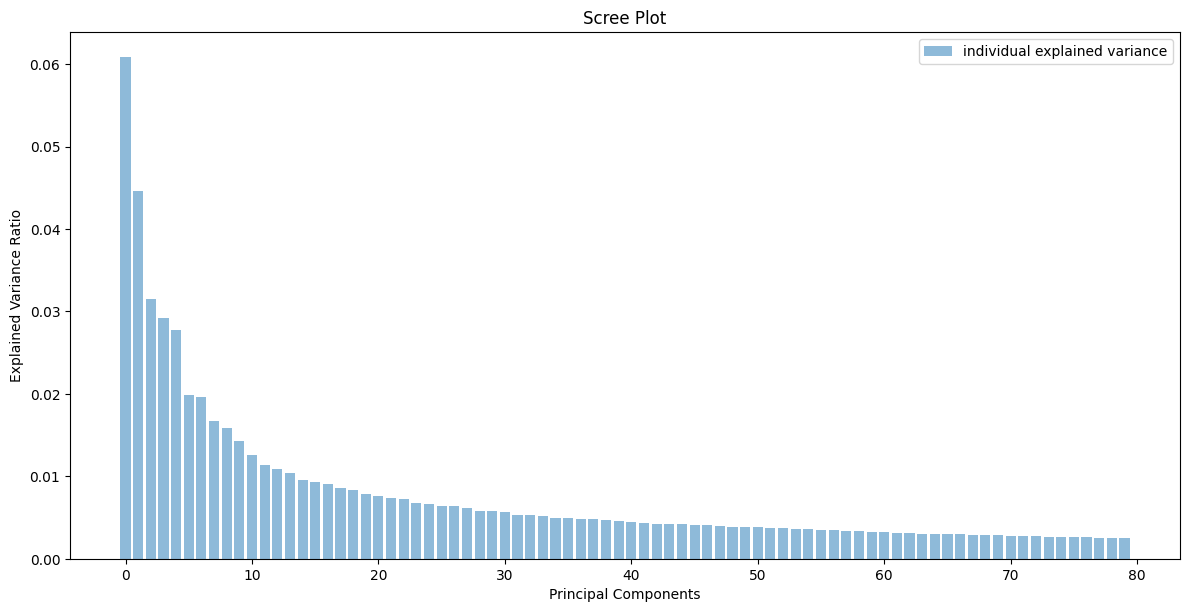

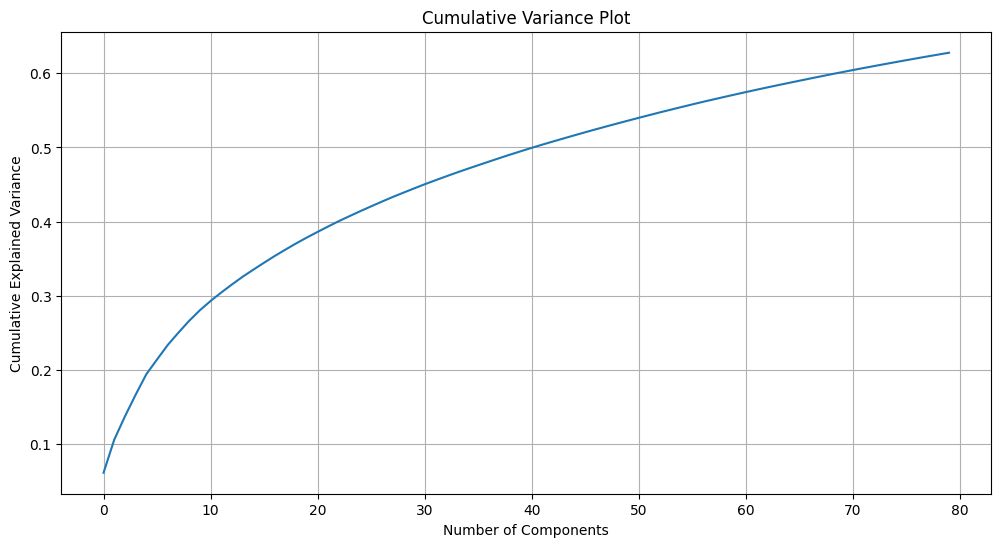

(array([0.06085081, 0.04464375, 0.0314536 , 0.02925002, 0.02769786,
        0.01985656, 0.01959352, 0.01665901, 0.01589795, 0.01425244,
        0.01256165, 0.01142811, 0.01088889, 0.01043201, 0.00955013,
        0.00936538, 0.00911009, 0.00860881, 0.00838829, 0.00790566,
        0.00758144, 0.00739943, 0.00722909, 0.00676257, 0.00665241,
        0.006432  , 0.00633758, 0.00618785, 0.00584047, 0.00573815,
        0.00568298, 0.00535721, 0.00528613, 0.00518922, 0.00498316,
        0.00489875, 0.00486649, 0.00480862, 0.00470731, 0.00459793,
        0.00448587, 0.00436815, 0.00423211, 0.00417975, 0.00415952,
        0.00409676, 0.0040443 , 0.00392173, 0.0038712 , 0.00383612,
        0.00379937, 0.00373034, 0.00370485, 0.00358975, 0.00357511,
        0.00353406, 0.00345623, 0.00333374, 0.00330785, 0.00327694,
        0.00322485, 0.00316858, 0.00311657, 0.00304685, 0.00301828,
        0.00297958, 0.00296621, 0.00292123, 0.00290279, 0.00282928,
        0.0027936 , 0.00273613, 0.00269742, 0.00

In [23]:
# 1. Explained Variance
explained_variance = pca.explained_variance_ratio_

# 2. Scree Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(explained_variance)), explained_variance,
        alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.title("Scree Plot")
plt.show()

# 3. Cumulative Variance Plot
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title("Cumulative Variance Plot")
plt.grid(True)
plt.show()

explained_variance, np.cumsum(explained_variance)

# 聚类

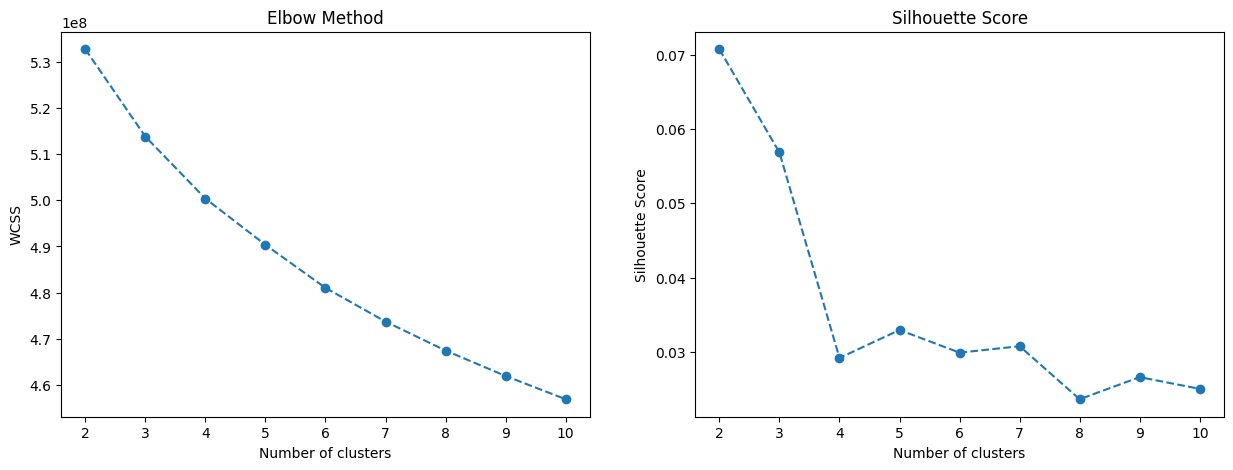

The optimal number of clusters is: 3


In [24]:
def find_elbow(wcss):
    # 获取点的坐标
    n_points = len(wcss)
    all_coords = np.vstack((range(n_points), wcss)).T
    first_point = all_coords[0]
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    
    # 计算每一点到线段的距离
    vec_from_first = all_coords - first_point
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    
    # 找到距离最大的点
    idx_of_elbow = np.argmax(dist_to_line)
    return idx_of_elbow

def find_optimal_clusters(data, max_k):
    wcss = []
    silhouette = []
    
    for k in range(2, max_k+1): 
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
        # 计算轮廓系数
        silhouette.append(silhouette_score(data, kmeans.labels_))
    
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # 绘制 WCSS 图形
    ax[0].plot(range(2, max_k+1), wcss, marker='o', linestyle='--')
    ax[0].set_title('Elbow Method')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    # 绘制轮廓系数图形
    ax[1].plot(range(2, max_k+1), silhouette, marker='o', linestyle='--')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette Score')
    
    plt.show()
    
    print(f"The optimal number of clusters is: {find_elbow(wcss)}")
    
find_optimal_clusters(reduced_features, max_k=10)

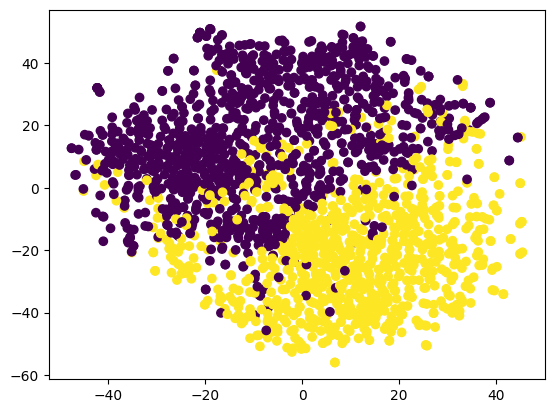

In [26]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters)
cluster_assignments = kmeans.fit_predict(reduced_features)

tsne = TSNE()
tsne_features = tsne.fit_transform(reduced_features)

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=cluster_assignments)
plt.show()

# 预览与保存

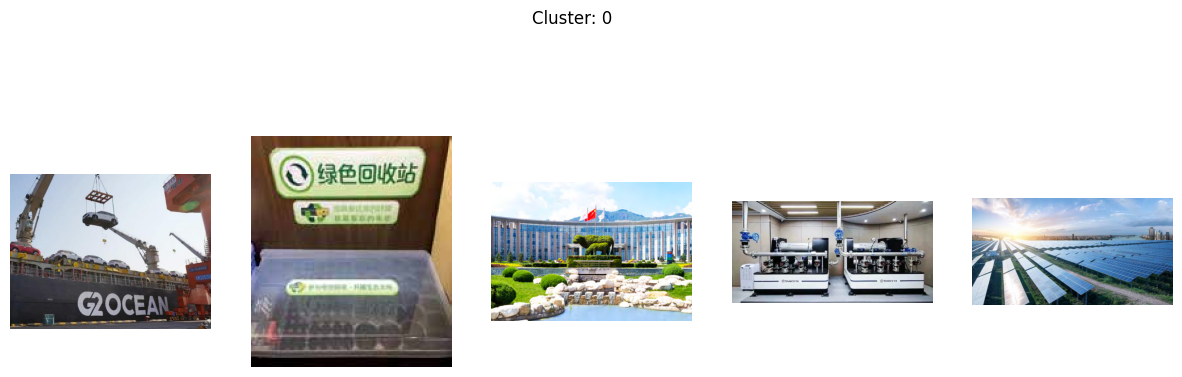

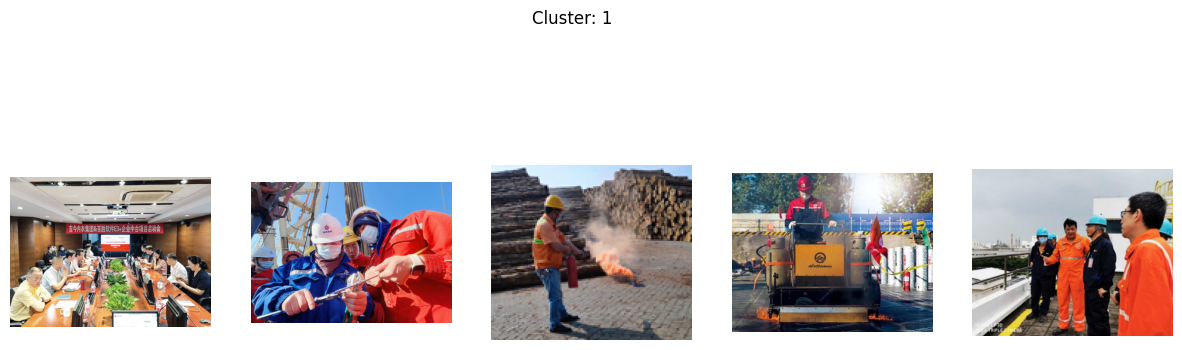

In [27]:
def visualize_clusters(image_paths, cluster_assignments, n_images_per_cluster=5):
    unique_clusters = set(cluster_assignments)
    
    for cluster in unique_clusters:
        # 获取此类的图片路径
        cluster_image_paths = [img for img, c in zip(image_paths, cluster_assignments) if c == cluster]
        
        # 随机选择 n_images_per_cluster 张图片
        sample_image_paths = cluster_image_paths[:n_images_per_cluster]
        
        # 显示图片
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f"Cluster: {cluster}")
        
        for i, img_path in enumerate(sample_image_paths):
            ax = fig.add_subplot(1, n_images_per_cluster, i + 1)
            ax.imshow(Image.open(img_path))
            ax.axis('off')
        
        plt.show()

# visualize_clusters(filtered_images, cluster_assignments, n_images_per_cluster=5)
visualize_clusters(image_paths, cluster_assignments, n_images_per_cluster=5)

In [28]:
def save_clusters_to_folders(image_paths, cluster_assignments, output_folder):
    # 创建输出文件夹（如果不存在）
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    # 根据聚类结果保存图片
    for img_path, cluster in zip(image_paths, cluster_assignments):
        cluster_folder = os.path.join(output_folder, f"cluster_{cluster}")
        
        if not os.path.exists(cluster_folder):
            os.mkdir(cluster_folder)
        
        shutil.copy(img_path, cluster_folder)

In [29]:
output_folder = "/Users/improvise/Desktop/保研/实证论文/ESG/Playground/folder_cluster 10/second_cluster"
# save_clusters_to_folders(filtered_images, cluster_assignments, output_folder)
save_clusters_to_folders(image_paths, cluster_assignments, output_folder)